In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import platform
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sklearn 
import cv2
import json
from glob import glob

In [2]:
device = torch.device('cuda')

In [3]:
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

- os: Windows-10-10.0.19041-SP0
- python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.3.5
- numpy: 1.19.1
- sklearn: 1.0.2
- pytorch: 1.10.1+cpu
- opencv: 4.5.5


In [4]:
def accuracy_function(real, pred):    
    score = f1_score(real, pred, average='macro')
    return score

def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

# 데이터 파악

In [5]:
train_csv = sorted(glob('./_data/train/*/*.csv'))
train_jpg = sorted(glob('./_data/train/*/*.jpg'))
train_json = sorted(glob('./_data/train/*/*.json'))

test_csv = sorted(glob('./_data/test/*/*.csv'))
test_jpg = sorted(glob('./_data/test/*/*.jpg'))
test_json = sorted(glob('./_data/test/*/*.json'))

In [6]:
print(f'train_csv: {len(train_csv)}')
print(f'train_jpg: {len(train_jpg)}')
print(f'train_json: {len(train_json)}')

print(f'test_csv: {len(test_csv)}')
print(f'test_jpg: {len(test_jpg)}')
print(f'test_json: {len(test_json)}')

train_csv: 5767
train_jpg: 5767
train_json: 5767
test_csv: 51906
test_jpg: 51906
test_json: 0


## train 데이터 5767개, test 데이터 51906개
### test 데이터 수에비해 train 데이터가 매우 적고 json데이터는 존재하지 않음

In [7]:
crop_dict = {1:'딸기', 
             2:'토마토',
             3:'파프리카',
             4:'오이', 
             5:'고추',
             6: '시설포도'}

area_dict = {1:'열매',
             2:'꽃',
             3:'잎',
             4:'가지',
             5:'줄기',
             6:'뿌리',
             7:'해충'}

task_dict = {0:'정상',
             1:'병해',
             2:'생리장애',
             3:'보호제처리반응'}

disease_dict = {'00' : '정상',
                
                # 병해 a
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                
                # 생리장애 b
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                
                # 보호제 처리반응 c
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

            # 시설 과채류
grow_dict = {11:'유묘기',
             12:'생장기',
             13:'착화/과실기',
             
             # 시설 과수류 (포도)
             21:'발아기',
             22:'개화기',
             23:'신초생장기',
             24:'과실성숙기',
             25:'수확기',
             26:'휴면기'}

risk_dict = {0:'정상',
             1:'초기',
             2:'중기',
             3:'말기'}

In [217]:
label_description = {
    "1_00_0" : "딸기", 
    "2_00_0" : "토마토",
    "2_a5_2" : "흰가루병_중기",
    "3_00_0" : "파프리카",
    "3_a9_1" : "흰가루병_초기",
    "3_a9_2" : "흰가루병_중기",
    "3_a9_3" : "흰가루병_말기",
    "3_b3_1" : "칼슘결핍_초기",
    "3_b6_1" : "다량원소결핍(N)_초기",
    "3_b7_1" : "다량원소결핍(P)_초기",
    "3_b8_1" : "다량원소결핍(K)_초기",
    "4_00_0" : "오이",
    "5_00_0" : "고추",
     "5_a7_2" : "탄저병_중기",
     "5_b6_1" : "다량원소결핍(N)_초기",
    "5_b7_1" : "다량원소결핍(P)_초기",
     "5_b8_1" : "다량원소결핍(K)_초기",
    "6_00_0" : "시설포도",
    "6_a11_1" : "탄저병_초기",
     "6_a11_2" : "탄저병_중기",
     "6_a12_1" : "노균병_초기",
    "6_a12_2" : "노균병_중기",
     "6_b4_1" : "일소피해_초기",
     "6_b4_3" : "일소피해_말기",
    "6_b5_1" : "축과병_초기"   
}

In [230]:
l = {    
    "딸기":0, 
    "토마토":1,
    "파프리카":2,
    "오이":3,
    "고추":4,
    "시설포도":5,
    "흰가루병_초기":6,
    "흰가루병_중기":7,
    "흰가루병_말기":8,
    "칼슘결핍_초기":9,
    "다량원소결핍(N)_초기":10,
    "다량원소결핍(P)_초기":11,
    "다량원소결핍(K)_초기":12,
    "탄저병_초기":13,
    "탄저병_중기":14,
    "노균병_초기":15,
    "노균병_중기":16,
    "일소피해_초기":17,
    "일소피해_말기":18,
    "축과병_초기":19   }

In [231]:
list(l.keys())

['딸기',
 '토마토',
 '파프리카',
 '오이',
 '고추',
 '시설포도',
 '흰가루병_초기',
 '흰가루병_중기',
 '흰가루병_말기',
 '칼슘결핍_초기',
 '다량원소결핍(N)_초기',
 '다량원소결핍(P)_초기',
 '다량원소결핍(K)_초기',
 '탄저병_초기',
 '탄저병_중기',
 '노균병_초기',
 '노균병_중기',
 '일소피해_초기',
 '일소피해_말기',
 '축과병_초기']

In [229]:
data['disease_label'] = data.labels.apply(lambda x: label_description[x])

In [232]:
data['disease_label'] = data.disease_label.apply(lambda x: l[x])

In [233]:
data['disease_label']

0       11
1        2
2        2
3        2
4        2
        ..
5762     2
5763     0
5764     7
5765     0
5766    10
Name: disease_label, Length: 5767, dtype: int64

In [187]:
len(data.disease_label.unique())

20

In [235]:
data.disease_label.unique()

array([11,  2,  3,  6,  0,  9, 12, 10,  5,  7,  1, 14,  8, 17,  4, 18, 13,
       15, 16, 19], dtype=int64)

In [236]:
[str(x) for x in data.disease_label.unique()]

['11',
 '2',
 '3',
 '6',
 '0',
 '9',
 '12',
 '10',
 '5',
 '7',
 '1',
 '14',
 '8',
 '17',
 '4',
 '18',
 '13',
 '15',
 '16',
 '19']

In [188]:
data.disease_label.unique().tolist()

['다량원소결핍(P)_초기',
 '파프리카_정상',
 '오이_정상',
 '흰가루병_초기',
 '딸기_정상',
 '칼슘결핍_초기',
 '다량원소결핍(K)_초기',
 '다량원소결핍(N)_초기',
 '시설포도_정상',
 '흰가루병_중기',
 '토마토_정상',
 '탄저병_중기',
 '흰가루병_말기',
 '일소피해_초기',
 '고추_정상',
 '일소피해_말기',
 '탄저병_초기',
 '노균병_초기',
 '노균병_중기',
 '축과병_초기']

In [8]:
def img_load(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (384, 512))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:27<00:00, 212.18it/s]


In [9]:
crops = []
areas = []
tasks = []
diseases = []
risks = []
grows = []
labels = []
dates = []
times = []
parts=[]
roi = []
for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        
        crop = sample['annotations']['crop']
        area = sample['annotations']['area']
        task = sample['description']['task']
        grow = sample['annotations']['grow']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        date = sample['description']['date']
        time = sample['description']['time']
        label=f"{crop}_{disease}_{risk}"        
        
        crops.append(crop)
        areas.append(area)
        tasks.append(task)
        grows.append(grow)
        diseases.append(disease)
        risks.append(risk)
        dates.append(date)
        times.append(time)
        labels.append(label)
        
        
        r = sample['annotations']['bbox'][0]
        temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
        roi.append(temp)    
        
        p = []
        
        for part in sample['annotations']['part']:
            p.append({
                'bbox': [
                    int(part['x']), int(part['y']), int(part['w']), int(part['h'])
                ],
                'id': part['id']
            })
        parts.append(p)

# 데이터 확인
## 데이터 변수 설명 파일을 통해 확인한 것
* 시설과채류 : 딸기, 토마토, 파프리카, 오이, 고추
* 시설과수류 : 포도

### a. 병해
* 시설과채류는 모두 흰가루 병에 걸릴 수 있음
* 시설과채류 중 딸기와 토마토는 잿빛곰팡이, 파프리카는 잘록, 오이는 노균, 고추는 탄저병에 걸릴 수 있음
* 시설과수류인 포도는 노균과 탄저병에 걸릴 수 있음

### b. 생리장애
* 시설과채류는 다량원소결핍 N,P,K에 걸릴 수 있음
* 냉해피해는 딸기와 오이
* 칼슘결핍은 토마토 파프리카
* 열과는 토마토
* 포도는 일소피해, 축과병

### c. 보호제처리반응 
* 각 작물마다 걸릴 수 있는 병해에 대한 보호제 처리반응

In [10]:
# 병해부위 갯수
parts_i = [len(x) for x in parts]

In [11]:
data = pd.DataFrame({'crops':crops,'areas':areas,'tasks':tasks,'diseases':diseases,'risks':risks, 'grows':grows, 'labels':labels, 'dates':dates, 'times':times, 'parts':parts_i})
data

crops  areas  tasks diseases  risks  grows  labels     dates times  \
0         3      3      2       b7      1     13  3_b7_1  20211126  0935   
1         3      5      0       00      0     11  3_00_0  20210914  0925   
2         3      1      0       00      0     13  3_00_0  20210624  1332   
3         3      3      0       00      0     11  3_00_0  20210915  1616   
4         3      1      0       00      0     13  3_00_0  20210624  1430   
...     ...    ...    ...      ...    ...    ...     ...       ...   ...   
5762      3      5      0       00      0     11  3_00_0  20210930  1234   
5763      1      3      0       00      0     11  1_00_0  20210916  0952   
5764      2      3      1       a5      2     12  2_a5_2  20211017  1249   
5765      1      3      0       00      0     12  1_00_0  20211007  0956   
5766      5      3      2       b6      1     13  5_b6_1  20211102  1141   

      parts  
0         2  
1         0  
2         0  
3         0  
4         0  
...     ...  
5762      0  
5763      0  
5764      1  
5765      0  
5766      1  

[5767 rows x 10 columns]

# 작물 분포 확인

In [12]:
data_txt = data.copy()
data_txt.crops = data_txt.crops.apply(lambda x: crop_dict[x]+'('+ str(x) +')')
data_txt.areas = data_txt.areas.apply(lambda x: area_dict[x]+'('+ str(x) +')')
data_txt.tasks = data_txt.tasks.apply(lambda x: task_dict[x]+'('+ str(x) +')')
data_txt.diseases = data_txt.diseases.apply(lambda x: disease_dict[x]+'('+ str(x) +')')
data_txt.risks = data_txt.risks.apply(lambda x: risk_dict[x]+'('+ str(x) +')')
data_txt.grows = data_txt.grows.apply(lambda x: grow_dict[x]+'('+ str(x) +')')
data_txt.labels = data_txt.labels.apply(lambda x: crop_dict[int(x.split('_')[0])] + '_' + disease_dict[x.split('_')[1]] + '_' + risk_dict[int(x.split('_')[2])])
data_txt

crops  areas    tasks        diseases  risks       grows  \
0     파프리카(3)   잎(3)  생리장애(2)  다량원소결핍 (P)(b7)  초기(1)  착화/과실기(13)   
1     파프리카(3)  줄기(5)    정상(0)          정상(00)  정상(0)     유묘기(11)   
2     파프리카(3)  열매(1)    정상(0)          정상(00)  정상(0)  착화/과실기(13)   
3     파프리카(3)   잎(3)    정상(0)          정상(00)  정상(0)     유묘기(11)   
4     파프리카(3)  열매(1)    정상(0)          정상(00)  정상(0)  착화/과실기(13)   
...       ...    ...      ...             ...    ...         ...   
5762  파프리카(3)  줄기(5)    정상(0)          정상(00)  정상(0)     유묘기(11)   
5763    딸기(1)   잎(3)    정상(0)          정상(00)  정상(0)     유묘기(11)   
5764   토마토(2)   잎(3)    병해(1)     토마토흰가루병(a5)  중기(2)     생장기(12)   
5765    딸기(1)   잎(3)    정상(0)          정상(00)  정상(0)     생장기(12)   
5766    고추(5)   잎(3)  생리장애(2)  다량원소결핍 (N)(b6)  초기(1)  착화/과실기(13)   

                  labels     dates times  parts  
0     파프리카_다량원소결핍 (P)_초기  20211126  0935      2  
1             파프리카_정상_정상  20210914  0925      0  
2             파프리카_정상_정상  20210624  1332      0  
3             파프리카_정상_정상  20210915  1616      0  
4             파프리카_정상_정상  20210624  1430      0  
...                  ...       ...   ...    ...  
5762          파프리카_정상_정상  20210930  1234      0  
5763            딸기_정상_정상  20210916  0952      0  
5764      토마토_토마토흰가루병_중기  20211017  1249      1  
5765            딸기_정상_정상  20211007  0956      0  
5766    고추_다량원소결핍 (N)_초기  20211102  1141      1  

[5767 rows x 10 columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5767 entries, 0 to 5766
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   crops     5767 non-null   int64 
 1   areas     5767 non-null   int64 
 2   tasks     5767 non-null   int64 
 3   diseases  5767 non-null   object
 4   risks     5767 non-null   int64 
 5   grows     5767 non-null   int64 
 6   labels    5767 non-null   object
 7   dates     5767 non-null   object
 8   times     5767 non-null   object
 9   parts     5767 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 450.7+ KB


In [14]:
import matplotlib
from matplotlib import font_manager, rc

font_path ="C:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)

# 촬영부위와 병해유무
## 열매와 잎에 발생한 병해 데이터만 있음

In [15]:
pd.crosstab(data_txt.tasks,data_txt.areas, margins=True).style.background_gradient()

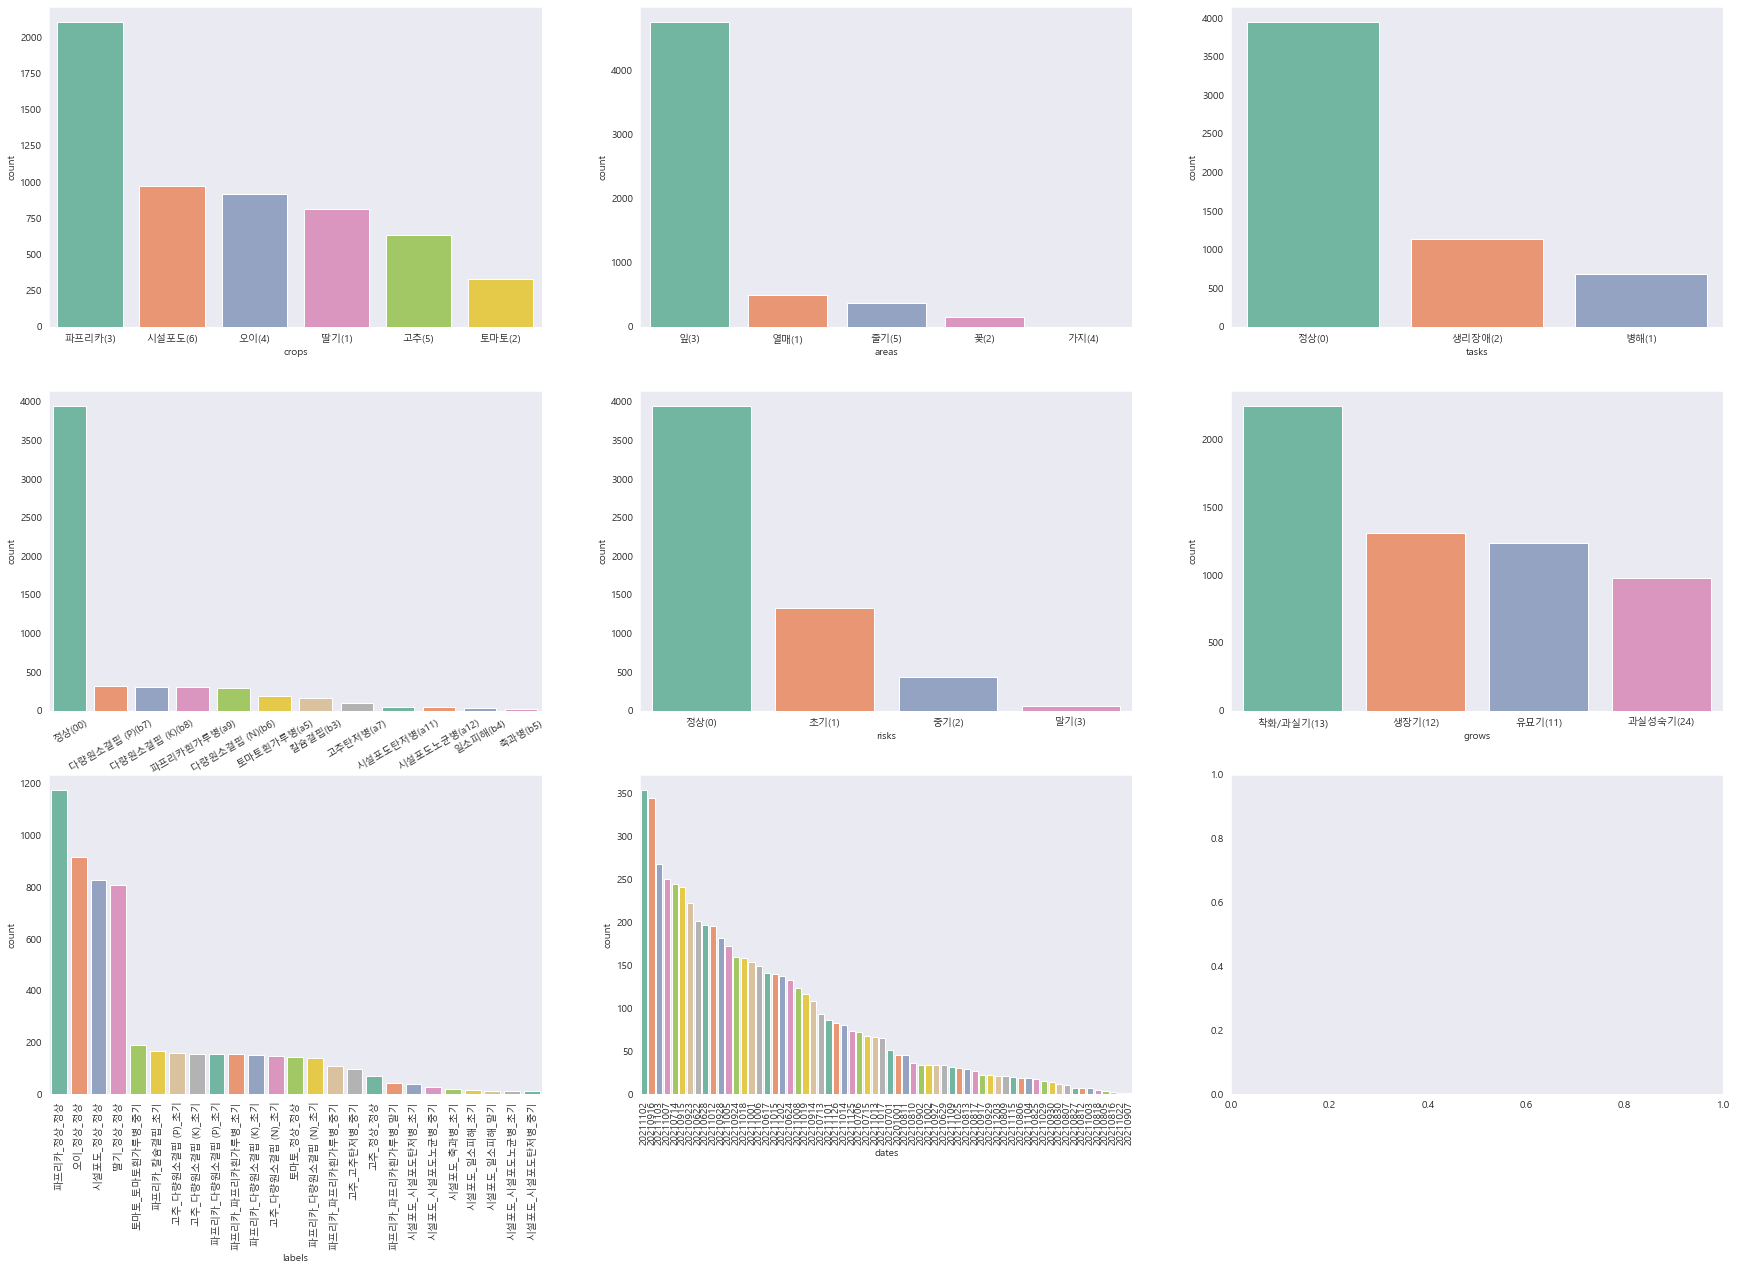

In [16]:
f, ax = plt.subplots(3,3, figsize=(30,20))
for i, col in enumerate(data_txt.columns.tolist()[:-2]):
    sns.countplot(x=data_txt[col], ax=ax[i//3][i%3], palette='Set2', order = data_txt[col].value_counts().index)
# diseases만 회전
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30)
ax[2,0].set_xticklabels(ax[2,0].get_xticklabels(), rotation=90)
ax[2,1].set_xticklabels(ax[2,1].get_xticklabels(), rotation=90)
plt.show()

# 데이터 불균형이 심함.
## 촬영 부위는 대부분 잎이고 질병이나 생리장애 데이터보다 정상 데이터가 훨씬 많음.
## 말기데이터 또한 부족
## 보호제 처리반응 데이터 없음

In [17]:
print(f'훈련 데이터 고유 라벨 수: {len(data.labels.unique())}')

훈련 데이터 고유 라벨 수: 25


In [18]:
pd.crosstab(data_txt.labels,data_txt.crops, margins=True).style.background_gradient()

# 부족한 데이터
## 딸기, 오이: 정상 이외 모두
## 토마토는 정상,흰가루 이외 모두
## 파프리카 잘록
## 고추 흰가루

## 딸기
개화기의 꽃이나 꽃봉오리는 온도에 민감해 0℃이하의 저온에 노출될 경우 냉해를 받아 꽃받침이 검게 변하거나 수술과 암술이 검게 변하고 화분발아가 불량하게 되어 기형과 발생과 잿빛곰팡이병의 발생 원인으로 작용하고 있다.

출처 : 월간원예(http://www.hortitimes.com)

In [19]:
data_txt.loc[data.risks==3, 'crops'].value_counts()

파프리카(3)    42
시설포도(6)    14
Name: crops, dtype: int64

In [20]:
data_txt.loc[data.risks==2, 'crops'].value_counts()

토마토(2)     189
파프리카(3)    111
고추(5)       99
시설포도(6)     41
Name: crops, dtype: int64

In [21]:
data_txt.loc[data.risks==1, 'crops'].value_counts()

파프리카(3)    771
고추(5)      464
시설포도(6)     92
Name: crops, dtype: int64

# 말기(3): 파프리카와 시설포도
# 중기(2): 토마토 고추 파프리카 시설포도
# 초기(1): 고추 파프리카 시설포도

# 파프리카(3) 초기/중기/말기에 따른 병해부위(part) 개수

In [22]:
data1 = data_txt.loc[(data.risks==3)& (data.crops==3), 'diseases']
data2 = data_txt.loc[(data.risks==3)& (data.crops==3), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

In [23]:
data1 = data_txt.loc[(data.risks==2)& (data.crops==3), 'diseases']
data2 = data_txt.loc[(data.risks==2)& (data.crops==3), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

In [24]:
data1 = data_txt.loc[(data.risks==1)& (data.crops==3), 'diseases']
data2 = data_txt.loc[(data.risks==1)& (data.crops==3), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

# 파프리카흰가루병만 초기 중기 말기 데이터가 존재함.

In [25]:
data1 = data_txt.loc[(data.risks==1)& (data.crops==5), 'diseases']
data2 = data_txt.loc[(data.risks==1)& (data.crops==5), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

In [26]:
data1 = data_txt.loc[(data.risks==2)& (data.crops==5), 'diseases']
data2 = data_txt.loc[(data.risks==2)& (data.crops==5), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

# 고추는 초기 원소결핍, 중기 탄저병

In [27]:
data1 = data_txt.loc[(data.risks==1)& (data.crops==6), 'diseases']
data2 = data_txt.loc[(data.risks==1)& (data.crops==6), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

In [28]:
data1 = data_txt.loc[(data.risks==2)& (data.crops==6), 'diseases']
data2 = data_txt.loc[(data.risks==2)& (data.crops==6), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

In [29]:
data1 = data_txt.loc[(data.risks==3)& (data.crops==6), 'diseases']
data2 = data_txt.loc[(data.risks==3)& (data.crops==6), 'parts']
pd.crosstab(data1,data2, margins=True).style.background_gradient()

# 포도
### 말기 일소피해
### 중기 노균,탄저병
### 초기 모두다

### 병해 부위갯수로 초/중/말기 판단은 어려울듯함

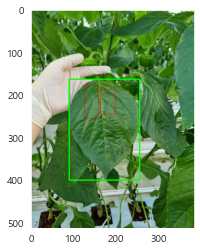

In [30]:
for i in range(1):
    x1, y1, x2, y2 = roi[i][0],roi[i][1],roi[i][0]+roi[i][2],roi[i][1]+roi[i][3]
    cv2.rectangle(imgs[i], (x1,y1),(x2,y2), (0,255,0),2)
    
    for p in parts[i]:
        x, y, w, h = p['bbox']
        cv2.rectangle(
            imgs[i],
            (x, y), (x+w, y+h),
            (255,0,0),
            1
        )
    plt.imshow(imgs[i])
    plt.show()

## 25개 라벨 중 이미지 샘플 하나씩 확인

In [31]:
data.labels.unique()

array(['3_b7_1', '3_00_0', '4_00_0', '3_a9_1', '1_00_0', '3_b3_1',
       '5_b8_1', '3_b8_1', '5_b6_1', '3_b6_1', '6_00_0', '2_a5_2',
       '3_a9_2', '2_00_0', '5_a7_2', '5_b7_1', '3_a9_3', '6_b4_1',
       '5_00_0', '6_b4_3', '6_a11_1', '6_a12_1', '6_a12_2', '6_b5_1',
       '6_a11_2'], dtype=object)

In [32]:
# import random

# choices = []
# for l in data.labels.unique().tolist():
#     choices.append(random.choice(data[data.labels==l].index))
choices = [14, 3943, 3839, 546, 5674, 3749, 3482, 5584, 3886, 3335, 937, 2505, 3422, 1480, 5301, 4409, 2447, 5727, 2373, 4403, 4469, 357, 1503, 2497, 5468]
print(choices)

[14, 3943, 3839, 546, 5674, 3749, 3482, 5584, 3886, 3335, 937, 2505, 3422, 1480, 5301, 4409, 2447, 5727, 2373, 4403, 4469, 357, 1503, 2497, 5468]


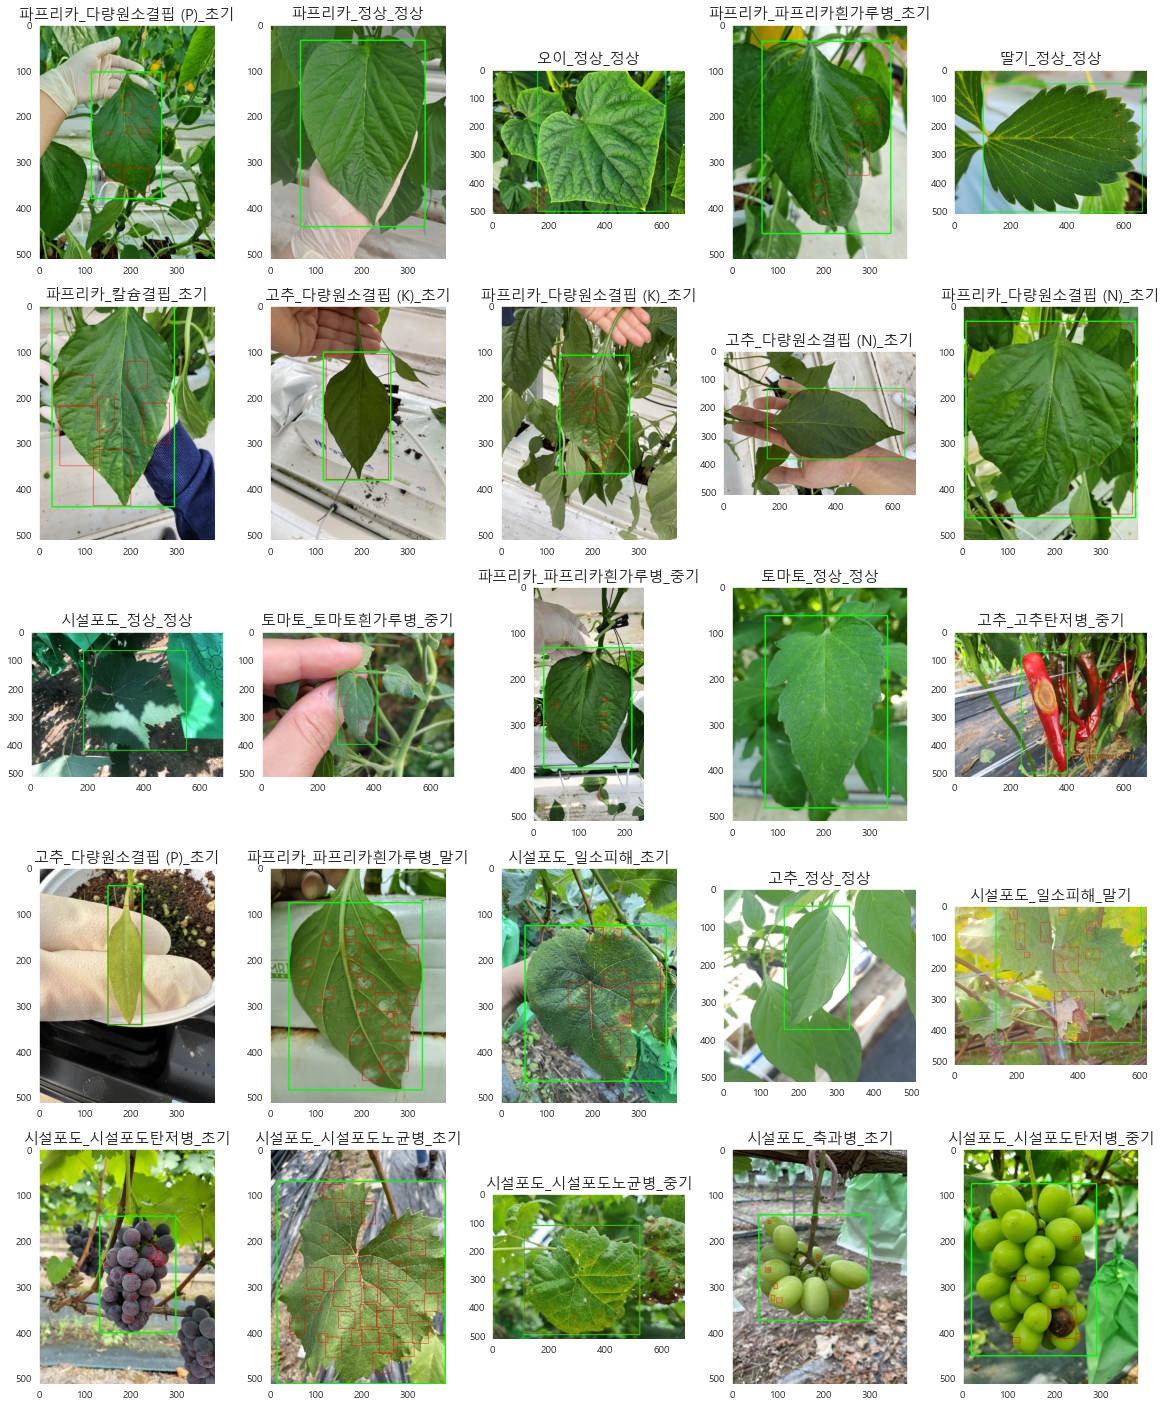

In [33]:
f, ax = plt.subplots(5,5, figsize=(20,25))
for i, c in enumerate(choices):
    x1, y1, x2, y2 = roi[c][0],roi[c][1],roi[c][0]+roi[c][2],roi[c][1]+roi[c][3]
    cv2.rectangle(imgs[c], (x1,y1),(x2,y2), (0,255,0),2)
    
    for p in parts[c]:
        x, y, w, h = p['bbox']
        cv2.rectangle(imgs[c], (x, y), (x+w, y+h), (255,0,0), 1)
        
    ax[i//5][i%5].imshow(imgs[c])
    ax[i//5][i%5].set_title(data_txt.iloc[c].labels, fontsize=15)
plt.show()

[153, 3762, 331, 40, 4916, 3292, 2568, 4274, 4980, 2507, 1346, 3385, 3567, 3614, 2142, 4199, 5751, 3967, 1125, 4967, 3246, 3818, 4197, 2206, 3337]


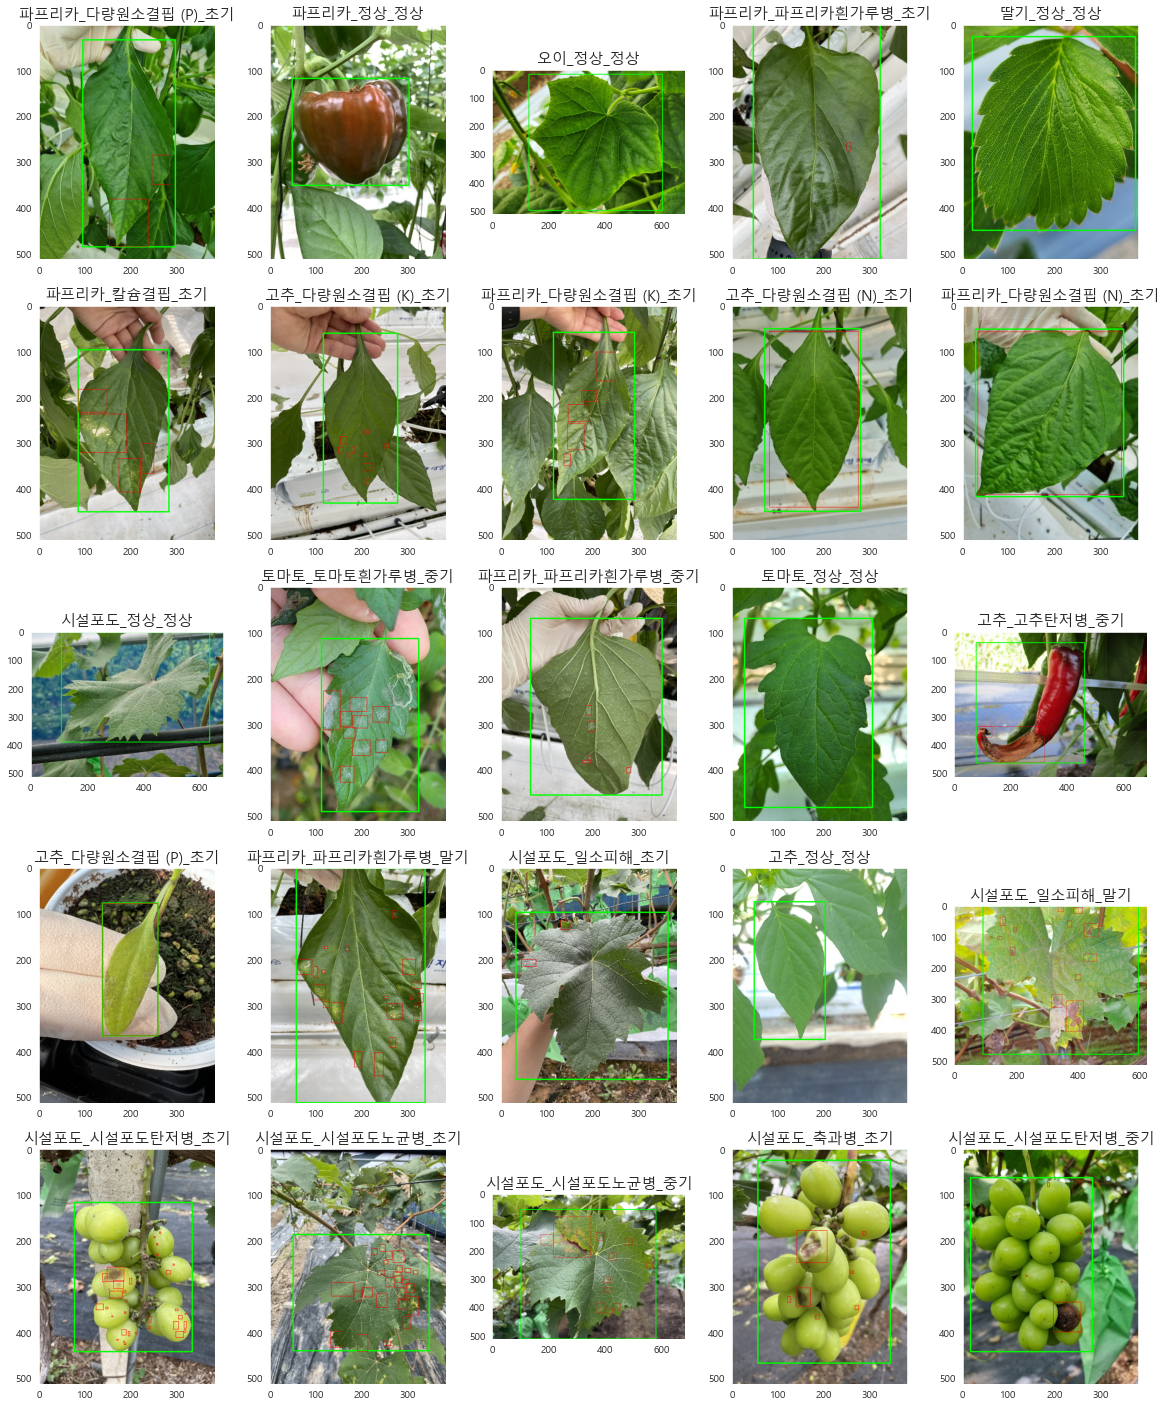

In [34]:
# choices = []
# for l in data.labels.unique().tolist():
#     choices.append(random.choice(data[data.labels==l].index))
choices = [153, 3762, 331, 40, 4916, 3292, 2568, 4274, 4980, 2507, 1346, 3385, 3567, 3614, 2142, 4199, 5751, 3967, 1125, 4967, 3246, 3818, 4197, 2206, 3337]
print(choices)

f, ax = plt.subplots(5,5, figsize=(20,25))
for i, c in enumerate(choices):
    x1, y1, x2, y2 = roi[c][0],roi[c][1],roi[c][0]+roi[c][2],roi[c][1]+roi[c][3]
    cv2.rectangle(imgs[c], (x1,y1),(x2,y2), (0,255,0),2)
    
    for p in parts[c]:
        x, y, w, h = p['bbox']
        cv2.rectangle(imgs[c], (x, y), (x+w, y+h), (255,0,0), 1)
        
    ax[i//5][i%5].imshow(imgs[c])
    ax[i//5][i%5].set_title(data_txt.iloc[c].labels, fontsize=15)
plt.show()

# csv 데이터 확인

In [35]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

min_dict = {x:x+'_min' for x in csv_features}
max_dict = {x:x+'_max' for x in csv_features}

In [41]:
for i, d in enumerate(train_csv):
    _min = pd.read_csv(d)[csv_features].min(axis=0)
    _max = pd.read_csv(d)[csv_features].max(axis=0)
    _min.rename(min_dict, axis=1, inplace=True)
    _max.rename(max_dict, axis=1, inplace=True)
    data.loc[i,list(min_dict.values())] = _min
    data.loc[i,list(max_dict.values())] = _max

crops  areas  tasks diseases  risks  grows  labels     dates times  \
0         3      3      2       b7      1     13  3_b7_1  20211126  0935   
1         3      5      0       00      0     11  3_00_0  20210914  0925   
2         3      1      0       00      0     13  3_00_0  20210624  1332   
3         3      3      0       00      0     11  3_00_0  20210915  1616   
4         3      1      0       00      0     13  3_00_0  20210624  1430   
...     ...    ...    ...      ...    ...    ...     ...       ...   ...   
5762      3      5      0       00      0     11  3_00_0  20210930  1234   
5763      1      3      0       00      0     11  1_00_0  20210916  0952   
5764      2      3      1       a5      2     12  2_a5_2  20211017  1249   
5765      1      3      0       00      0     12  1_00_0  20211007  0956   
5766      5      3      2       b6      1     13  5_b6_1  20211102  1141   

      parts  ...  내부 이슬점 최저_min  내부 온도 1 평균_max  내부 온도 1 최고_max  \
0         2  ...            1.7            18.6            18.7   
1         0  ...           14.1            30.7            30.7   
2         0  ...           15.2            29.5            29.6   
3         0  ...           13.7            29.4            29.6   
4         0  ...           15.2            29.5            29.6   
...     ...  ...            ...             ...             ...   
5762      0  ...           16.1            26.9            27.0   
5763      0  ...           11.9            31.6            32.2   
5764      1  ...            5.6            39.6            39.8   
5765      0  ...           13.6            31.7            32.1   
5766      1  ...            7.8            20.9            21.1   

      내부 온도 1 최저_max  내부 습도 1 평균_max  내부 습도 1 최고_max 내부 습도 1 최저_max  \
0               18.4            92.3            92.4           92.1   
1               30.6            94.7            94.9           94.6   
2               29.4            94.5            94.6           94.4   
3               29.3            93.4            93.6           93.3   
4               29.4            94.5            94.6           94.4   
...              ...             ...             ...            ...   
5762            26.8            96.4            96.4           96.4   
5763            30.8            90.5            90.6           90.4   
5764            39.4            99.5            99.5           99.4   
5765            31.4            95.4            95.8           95.2   
5766            20.6            88.3            88.5           88.0   

     내부 이슬점 평균_max 내부 이슬점 최고_max  내부 이슬점 최저_max  
0             11.0          11.7           10.2  
1             22.0          22.1           21.7  
2             20.8          21.3           20.4  
3             20.9          21.3           20.5  
4             20.8          21.3           20.4  
...            ...           ...            ...  
5762          22.4          22.4           22.4  
5763          21.2          21.9           20.7  
5764          33.6          34.0           32.7  
5765          24.4          25.6           23.9  
5766          13.0          13.2           12.8  

[5767 rows x 28 columns]

### 병해입은 작물이 어떤 환경에 있었는지 확인하기

In [92]:
temp_dict = {}
for i in range(len(imgs)):
    try:
        temp_dict[str(imgs[i].shape)] += 1
    except:
        temp_dict[str(imgs[i].shape)] = 1

In [93]:
temp_dict

{'(512, 384, 3)': 3349,
 '(512, 682, 3)': 2000,
 '(512, 740, 3)': 51,
 '(512, 242, 3)': 246,
 '(512, 262, 3)': 68,
 '(512, 622, 3)': 14,
 '(512, 512, 3)': 25,
 '(512, 1081, 3)': 14}

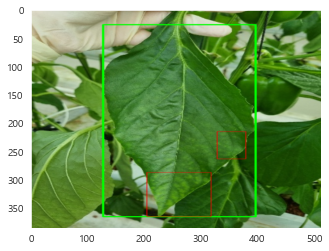

In [96]:
cv2.rectangle(temp_img,)
plt.imshow(temp_img)

In [108]:
(roi[0], roi[1])

([89, 162, 165, 237], [166, 2, 48, 315])

In [114]:
imgs[0].shape

(512, 384, 3)

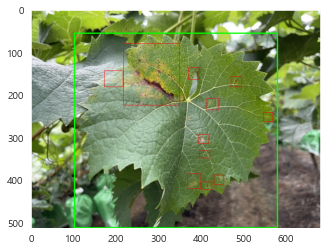

In [131]:
plt.imshow(imgs[4197])

In [157]:
train_jpg[4197]

'./_data/train\\52568\\52568.jpg'

In [172]:
data.loc[0].disease_label

18

In [169]:
# IMG_WIDTH = 384
# IMG_HEIGHT = 512

# for i in range(1):
#     temp_img = cv2.resize(imgs[i], (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
#     x1,y1,w,h = roi[i]
#     x2, y2 = x1+w, y1+h
#     x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
# #     cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
    
#     #yolov5용 좌표
#     with open(txt_dir, 'w') as f:
#         txt_dir = train_jpg[i].replace('.jpg', '.txt')
        
#         #if data.loc[i].disease_label==0:
#         x1, y1, x2, y2 = x1/IMG_WIDTH, y1/IMG_HEIGHT, x2/IMG_WIDTH, y2/IMG_HEIGHT
#         s = str(data.loc[i].crops-1) + ' ' + str(x1)+ ' ' + str(y1)+ ' ' + str(x2)+ ' ' + str(y2) + '\n'
#         f.write(s)
        
#         for j in parts[i]:
#             x1,y1,w,h = j['bbox']
#             x2, y2 = x1+w, y1+h
#             x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0]
#              #yolov5용 좌표
#             x1, y1, x2, y2 = x1/IMG_WIDTH, y1/IMG_HEIGHT, x2/IMG_WIDTH, y2/IMG_HEIGHT
#             s = str(data.loc[i].disease_label) + ' ' + str(x1)+ ' ' + str(y1)+ ' ' + str(x2)+ ' ' + str(y2) + '\n'
#             f.write(s)
            
#         cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
# plt.imshow(temp_img)


In [189]:
train_jpg

['./_data/train\\10027\\10027.jpg',
 './_data/train\\10037\\10037.jpg',
 './_data/train\\10043\\10043.jpg',
 './_data/train\\10045\\10045.jpg',
 './_data/train\\10063\\10063.jpg',
 './_data/train\\10090\\10090.jpg',
 './_data/train\\10109\\10109.jpg',
 './_data/train\\10115\\10115.jpg',
 './_data/train\\10117\\10117.jpg',
 './_data/train\\10118\\10118.jpg',
 './_data/train\\10124\\10124.jpg',
 './_data/train\\10169\\10169.jpg',
 './_data/train\\10173\\10173.jpg',
 './_data/train\\10192\\10192.jpg',
 './_data/train\\10199\\10199.jpg',
 './_data/train\\10201\\10201.jpg',
 './_data/train\\10224\\10224.jpg',
 './_data/train\\10226\\10226.jpg',
 './_data/train\\10238\\10238.jpg',
 './_data/train\\10251\\10251.jpg',
 './_data/train\\10252\\10252.jpg',
 './_data/train\\10263\\10263.jpg',
 './_data/train\\10274\\10274.jpg',
 './_data/train\\10299\\10299.jpg',
 './_data/train\\10300\\10300.jpg',
 './_data/train\\10304\\10304.jpg',
 './_data/train\\10323\\10323.jpg',
 './_data/train\\10328\\1032

In [234]:
IMG_WIDTH = 384
IMG_HEIGHT = 512

for i, img_path in enumerate(train_jpg):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/train_data/images/{i}.jpg', img)
    x1,y1,w,h = roi[i]
#     x2, y2 = x1+w, y1+h
#     x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
#     cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
    
    txt_dir = train_jpg[i].replace('.jpg', '.txt')

    #yolov5용 좌표
    with open(f'C:/git/jonie_github/VISION/_data/train_data/labels/{i}.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x, y, w, h = x/IMG_WIDTH, y/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(data.loc[i].crops-1) + ' ' + str(x)+ ' ' + str(y)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
        
        for j in parts[i]:
            x1,y1,w,h = j['bbox']
#             x2, y2 = x1+w, y1+h
#             x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0]
            x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

             #yolov5용 좌표
            x, y, w, h = x/IMG_WIDTH, y/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
            s = str(data.loc[i].disease_label) + ' ' + str(x)+ ' ' + str(y)+ ' ' + str(w)+ ' ' + str(h) + '\n'
            f.write(s)
            
#         cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
# plt.imshow(temp_img)


In [ ]:
# with open('./_data/train.txt', 'w') as f:
#     for jpg_dir in train_jpg:
#         f.write(jpg_dir+'\n')
        
# with open('./_data/test.txt', 'w') as f:
#     for jpg_dir in test_jpg:
#         f.write(jpg_dir+'\n')    